In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
dc = pd.read_csv('/Users/justinsmith/Documents/GitHub/DC_Properties.csv')

In [3]:
# Main Data to be looked set.

dc_re = dc.dropna(subset=['PRICE'])

In [4]:
# Check out info for cleaning

dc_re.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98216 entries, 0 to 158955
Data columns (total 49 columns):
Unnamed: 0            98216 non-null int64
BATHRM                98216 non-null int64
HF_BATHRM             98216 non-null int64
HEAT                  98216 non-null object
AC                    98216 non-null object
NUM_UNITS             57900 non-null float64
ROOMS                 98216 non-null int64
BEDRM                 98216 non-null int64
AYB                   98104 non-null float64
YR_RMDL               57674 non-null float64
EYB                   98216 non-null int64
STORIES               57867 non-null float64
SALEDATE              98215 non-null object
PRICE                 98216 non-null float64
QUALIFIED             98216 non-null object
SALE_NUM              98216 non-null int64
GBA                   57900 non-null float64
BLDG_NUM              98216 non-null int64
STYLE                 57900 non-null object
STRUCT                57900 non-null object
GRADE       

Here we see two numbers repeated (40316, 57900) and add up to our total dataset. 

In [30]:
# This problem is solved by dividing into residential and condominium.

dc_re_resid = dc_re[dc_re['SOURCE'] == 'Residential']
dc_re_condo = dc_re[dc_re['SOURCE'] != 'Residential']

In [31]:
# examine data for errors

dc_re['diff_yr'] = abs(dc_re['EYB']-dc_re['YR_RMDL'])

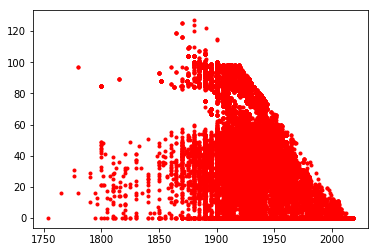

In [32]:
# Plot The year built compared to the difference in efficency year built and year remodeled to help fill
# 'YR_RMDL' data column.

plt.plot(dc_re['AYB'], dc_re['diff_yr'], 'r.')

In [33]:
# Drop major outlier with clearly inaccurate data so we can see the others. 

dc_re = dc_re.drop(index=56600)

KeyError: 'labels [56600] not contained in axis'

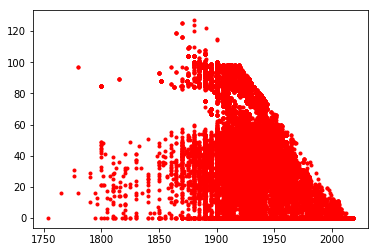

In [35]:
plt.plot(dc_re['AYB'], dc_re['diff_yr'], 'r.')

In [36]:
# Filling in null values of 'AYB' and 'YR_RMDL' with 0.

dc_re['AYB'] = dc_re['AYB'].fillna(0)
dc_re['YR_RMDL'] = dc_re['YR_RMDL'].fillna(0)

In [37]:
# Filling zeros on both AYB and YR_RMDL

for i in range(len(dc_re)):
    if dc_re.iloc[i,8] == 0:
        dc_re.iloc[i,8] = dc_re.iloc[i,10]

for i in range(len(dc_re)):
    if dc_re.iloc[i,9] == 0:
        dc_re.iloc[i,9] = dc_re.iloc[i,10]

In [38]:
# Filling in bad data. Several instances of 'AYB' or 'YR_RMDL' ahead of 'EYB'

for i in range(len(dc_re)):
    if dc_re.iloc[i,8] > dc_re.iloc[i,10]:
        dc_re.iloc[i,10] = dc_re.iloc[i,8]
        
for i in range(len(dc_re)):
    if dc_re.iloc[i,10] > dc_re.iloc[i,9]:
        dc_re.iloc[i,9] = dc_re.iloc[i,10]

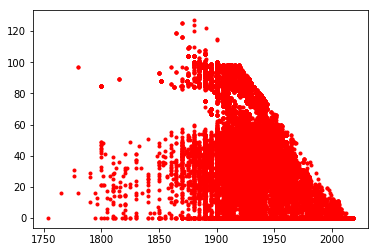

In [39]:
# Update categories to verify

dc_re['diff_yr'] = abs(dc_re['EYB']-dc_re['YR_RMDL'])
plt.plot(dc_re['AYB'], dc_re['diff_yr'], 'r.')
plt.show()

In [40]:
dc_re_resid = dc_re[dc_re['SOURCE'] == 'Residential']
dc_re_condo = dc_re[dc_re['SOURCE'] != 'Residential']

In [41]:
# DEALING WITH NULLS AND COLUMNS

dc_re_resid.dropna(axis=1, how='all', inplace=True)
dc_re_resid.drop(columns=['Unnamed: 0','FULLADDRESS', 'CENSUS_BLOCK', 'diff_yr', 'NATIONALGRID',
                          'ASSESSMENT_SUBNBHD','X','Y','GIS_LAST_MOD_DTTM','SOURCE',
                          'QUADRANT', 'CITY', 'STATE'], inplace=True)
dc_re_resid.dropna(inplace=True)

In [42]:
# DEALING WITH NULLS AND COLUMNS

dc_re_condo.dropna(axis=1, how='all', inplace=True)
dc_re_condo.drop(columns=['Unnamed: 0','diff_yr', 'ASSESSMENT_SUBNBHD','X','Y',
                          'GIS_LAST_MOD_DTTM','SOURCE', 'QUADRANT'], inplace=True)
dc_re_condo.dropna(inplace=True)

In [43]:
# Getting data into more useable formats 

dc_re_resid['SALEDATE']  = pd.to_datetime(dc_re_resid['SALEDATE']).dt.date
dc_re_resid['SALEDATE'] = pd.to_datetime(dc_re_resid['SALEDATE'])

dc_re_resid['WARD'] = dc_re_resid['WARD'].str.extract('(\d+)', expand=False)
dc_re_resid['WARD'] = dc_re_resid['WARD'].astype('int')

dc_re_resid['SQUARE'].replace(to_replace='PAR ', value= 6999, inplace=True)
dc_re_resid['SQUARE'] = dc_re_resid['SQUARE'].astype('int')

dc_re_resid['USECODE'] = dc_re_resid['USECODE'].astype('int')

In [44]:
# Dealing with date of sale data. Turning into month and year column only

dc_re_resid[['year','month','day']] = dc_re_resid.SALEDATE.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
dc_re_resid.drop(columns=['day','SALEDATE'], inplace=True)


In [45]:
dc_re_resid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57864 entries, 0 to 106695
Data columns (total 36 columns):
BATHRM             57864 non-null int64
HF_BATHRM          57864 non-null int64
HEAT               57864 non-null object
AC                 57864 non-null object
NUM_UNITS          57864 non-null float64
ROOMS              57864 non-null int64
BEDRM              57864 non-null int64
AYB                57864 non-null float64
YR_RMDL            57864 non-null float64
EYB                57864 non-null float64
STORIES            57864 non-null float64
PRICE              57864 non-null float64
QUALIFIED          57864 non-null object
SALE_NUM           57864 non-null int64
GBA                57864 non-null float64
BLDG_NUM           57864 non-null int64
STYLE              57864 non-null object
STRUCT             57864 non-null object
GRADE              57864 non-null object
CNDTN              57864 non-null object
EXTWALL            57864 non-null object
ROOF               57864 non

In [46]:
# Turning Grade and Condition into Rankings

dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Low Quality'] = 0
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Fair Quality'] = 1
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Average'] = 2
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Above Average'] = 3
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Good Quality'] = 4
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Very Good'] = 5
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Excellent'] = 6
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Superior'] = 7
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Exceptional-A'] = 8
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Exceptional-B'] = 9
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Exceptional-C'] = 10
dc_re_resid['GRADE'][dc_re_resid['GRADE'] == 'Exceptional-D'] = 11

In [47]:
dc_re_resid['CNDTN'][dc_re_resid['CNDTN'] == 'Poor'] = 0
dc_re_resid['CNDTN'][dc_re_resid['CNDTN'] == 'Fair'] = 1
dc_re_resid['CNDTN'][dc_re_resid['CNDTN'] == 'Average'] = 2
dc_re_resid['CNDTN'][dc_re_resid['CNDTN'] == 'Good'] = 3
dc_re_resid['CNDTN'][dc_re_resid['CNDTN'] == 'Very Good'] = 4
dc_re_resid['CNDTN'][dc_re_resid['CNDTN'] == 'Excellent'] = 5

In [48]:
dc_re_resid.drop([4549, 20036, 25208,104206], inplace=True)

In [49]:
# Turning qualified into boolean 

dc_re_resid['QUALIFIED'][dc_re_resid['QUALIFIED'] == 'Q'] = 1
dc_re_resid['QUALIFIED'][dc_re_resid['QUALIFIED'] == 'U'] = 0

In [50]:
# Changing data types

dc_re_resid['QUALIFIED'] = dc_re_resid['QUALIFIED'].astype('int')
dc_re_resid['GRADE'] = dc_re_resid['GRADE'].astype('int')
dc_re_resid['CNDTN'] = dc_re_resid['CNDTN'].astype('int')
dc_re_resid['year'] = dc_re_resid['year'].astype('int')
dc_re_resid['month'] = dc_re_resid['month'].astype('int')

In [51]:
dc_re_resid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57860 entries, 0 to 106695
Data columns (total 36 columns):
BATHRM             57860 non-null int64
HF_BATHRM          57860 non-null int64
HEAT               57860 non-null object
AC                 57860 non-null object
NUM_UNITS          57860 non-null float64
ROOMS              57860 non-null int64
BEDRM              57860 non-null int64
AYB                57860 non-null float64
YR_RMDL            57860 non-null float64
EYB                57860 non-null float64
STORIES            57860 non-null float64
PRICE              57860 non-null float64
QUALIFIED          57860 non-null int64
SALE_NUM           57860 non-null int64
GBA                57860 non-null float64
BLDG_NUM           57860 non-null int64
STYLE              57860 non-null object
STRUCT             57860 non-null object
GRADE              57860 non-null int64
CNDTN              57860 non-null int64
EXTWALL            57860 non-null object
ROOF               57860 non-nu

(0, 5100000)

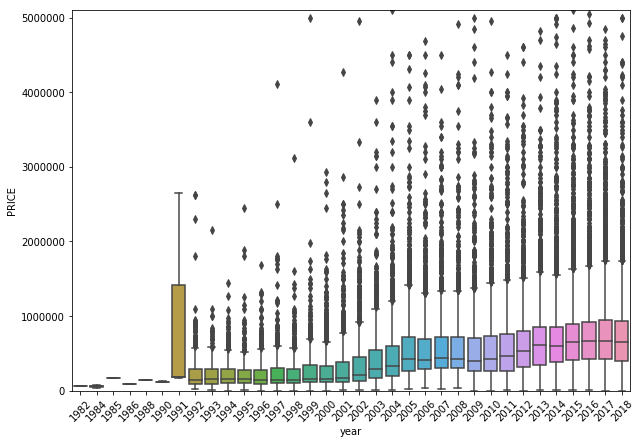

In [103]:
plt.figure(figsize=(10,7))
sns.boxplot(dc_re_resid['year'], dc_re_resid['PRICE'])
plt.xticks(rotation=45)
plt.ylim(0,5100000)

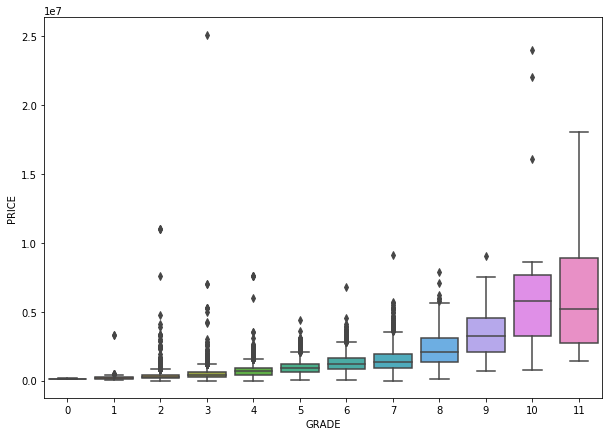

In [74]:
plt.figure(figsize=(10,7))
sns.boxplot(dc_re_resid['GRADE'], dc_re_resid['PRICE'])

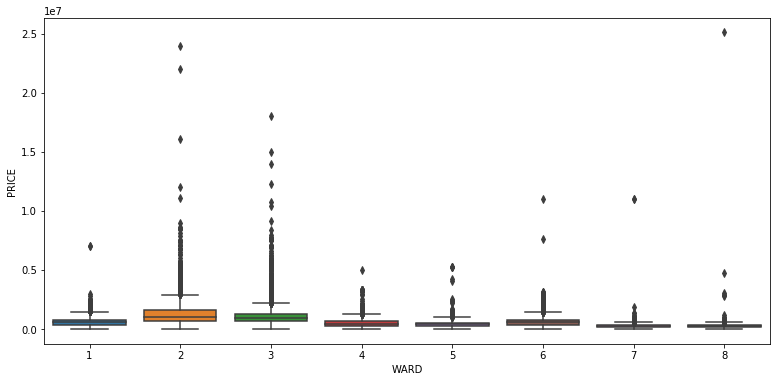

In [76]:
plt.figure(figsize=(13,6))
sns.boxplot(dc_re_resid['WARD'], dc_re_resid['PRICE'])


(0, 6000000)

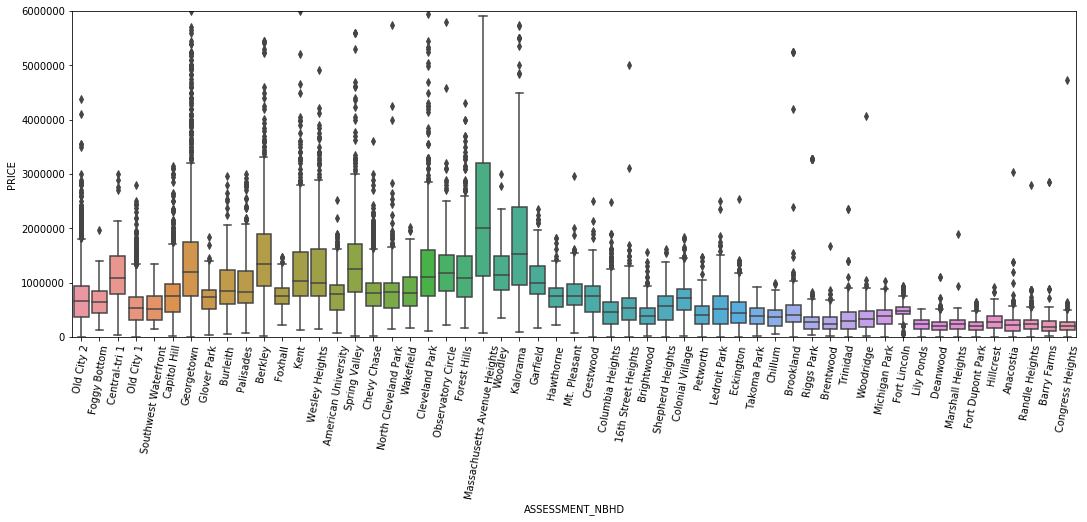

In [108]:
plt.figure(figsize=(18,6))
sns.boxplot(dc_re_resid['ASSESSMENT_NBHD'], dc_re_resid['PRICE'])
plt.xticks(rotation=80)
plt.ylim(0,6000000)

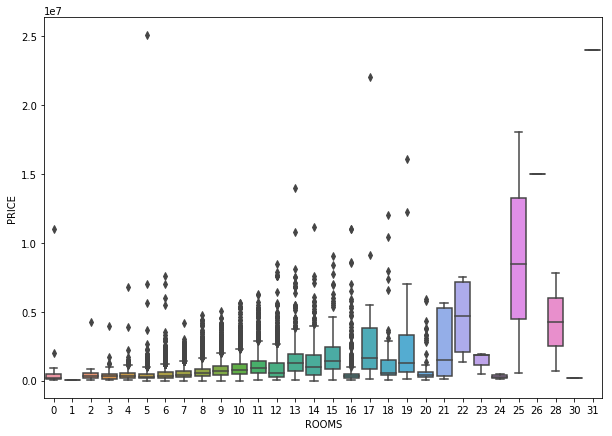

In [81]:
plt.figure(figsize=(10,7))
sns.boxplot(dc_re_resid['ROOMS'], dc_re_resid['PRICE'])

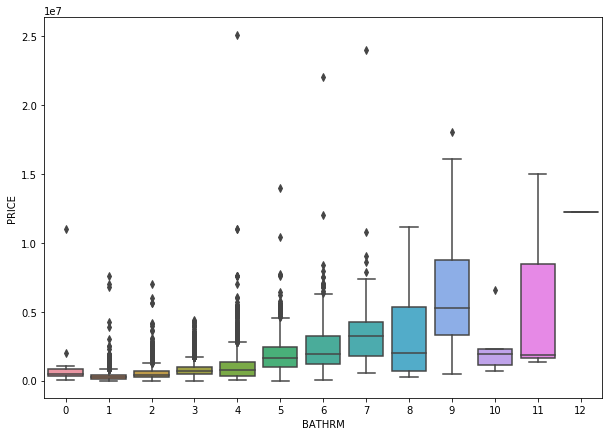

In [82]:
plt.figure(figsize=(10,7))
sns.boxplot(dc_re_resid['BATHRM'], dc_re_resid['PRICE'])

(0, 5000000)

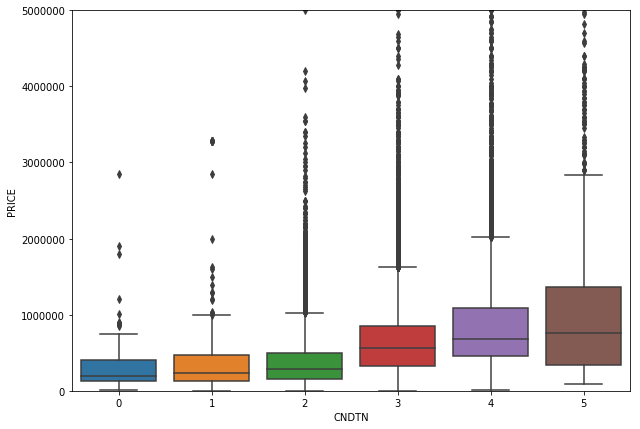

In [86]:
plt.figure(figsize=(10,7))
sns.boxplot(dc_re_resid['CNDTN'], dc_re_resid['PRICE'])
plt.ylim(0,5000000)

In [129]:
bins = pd.cut(dc_re_resid['GBA'], bins=8)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

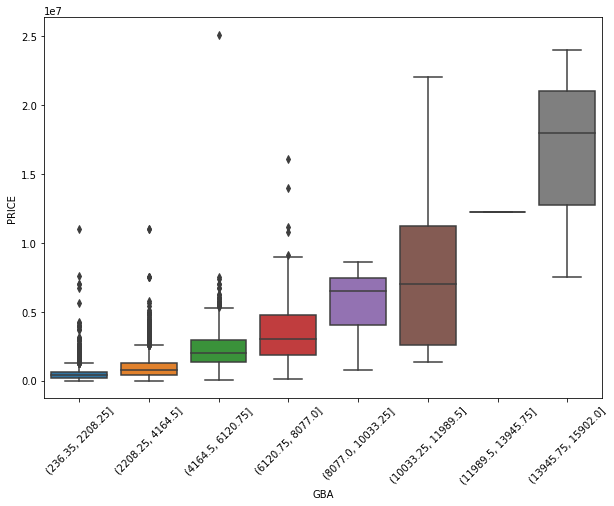

In [130]:
plt.figure(figsize=(10,7))
sns.boxplot(bins, dc_re_resid['PRICE'])
plt.xticks(rotation=45)

(0, 5000000)

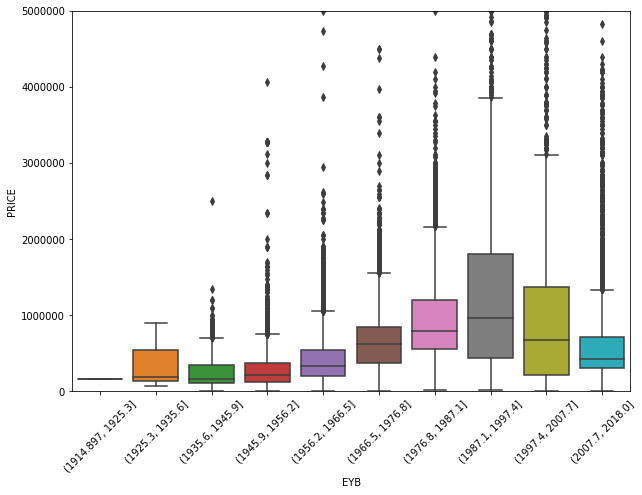

In [134]:
bins2= pd.cut(dc_re_resid['EYB'], bins=10)
plt.figure(figsize=(10,7))
sns.boxplot(bins2, dc_re_resid['PRICE'])
plt.xticks(rotation=45)
plt.ylim(0,5000000)

In [88]:
# Create dummies for categorical variables 

dc_re_resid_dummies = pd.get_dummies(dc_re_resid)

In [89]:
# Divid into independent and dependent variables

X = dc_re_resid_dummies.drop(columns='PRICE')
y = dc_re_resid_dummies['PRICE'].values.reshape(-1, 1)

In [90]:
# Split into train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [91]:
# Initial look at regression. Setting a baseline for improvement

regr_init = linear_model.LinearRegression()

In [92]:
regr_init.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [93]:
print('\nCoefficients: \n', regr_init.coef_)
print('\nIntercept: \n', regr_init.intercept_)
print('\nR-squared:')
print(regr_init.score(X_train, y_train))


Coefficients: 
 [[ 4.67787409e+04  1.86537043e+04 -1.48774595e+05 -1.84207071e+03
  -1.25558518e+04 -1.38307397e+03 -1.34715124e+03  1.20548369e+03
   3.00514178e+01 -8.20948637e+04  4.39813067e+03  2.44336145e+02
   1.47394843e+06  7.72278555e+04  9.26254412e+04  6.79214805e+04
   4.40806391e+04  3.46727699e+03  2.59752576e+01  1.74175931e+01
  -1.45747178e+06 -2.60449625e+06 -5.29279427e+00 -1.64193719e+04
  -6.58662445e-01  2.60340913e+04  1.47967029e+03 -3.86043852e+04
   3.49887574e+04 -3.92522895e+04 -1.53594403e+04 -3.09895802e+04
  -1.57565867e+04  3.44928833e+04 -2.74744090e+04 -1.69037525e+04
  -3.10996476e+04  1.60707386e+05 -2.47982612e+04  7.59621592e+03
   2.45310944e+03 -1.48271837e+05  9.24251873e+04  5.58466499e+04
   6.65619801e+04  7.86082033e+03  9.57370117e+04 -1.00371316e+04
  -2.63975063e+04 -3.91376893e+04 -7.10708242e+04 -8.93201456e+04
  -1.50025590e+05 -7.09243977e+04  1.98676624e+05 -1.88339502e+05
   1.05468150e+05 -1.20371981e+05  2.90470498e+05  1.002553

In [94]:
y_pred_init_train = regr_init.predict(X_train)

Text(0.7,0.25,'MEASURE IN 10mil')

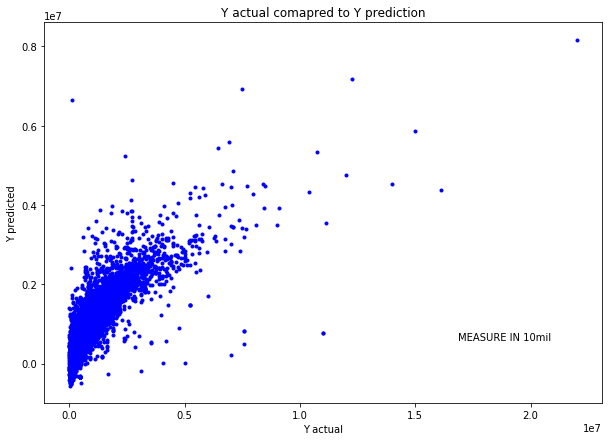

In [146]:
plt.figure(figsize=(10,7))
plt.plot(y_train, y_pred_init_train, 'b.')
plt.title('Y actual comapred to Y prediction')
plt.xlabel('Y actual')
plt.ylabel('Y predicted')
plt.figtext(y= .25, x= .7, s='MEASURE IN 10mil')

In [147]:
rmse_train = sqrt(mean_squared_error(y_train,y_pred_init_train))

In [148]:
print('The root mean squared error of initial training is:', rmse_train)

The root mean squared error of initial training is: 311056.32878135


In [149]:
regr_init.fit(X_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
y_pred_init_test = regr_init.predict(X_test)
rmse_test = sqrt(mean_squared_error(y_test,y_pred_init_test))
print('The root mean squared error of initial training is:', rmse_test)

The root mean squared error of initial training is: 399924.4484126745


In [151]:
rfr_init = RandomForestRegressor(n_estimators=50, warm_start=True, random_state=25)

In [152]:
rfr_init.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=25, verbose=0, warm_start=True)

In [187]:
rfr_init.score(X_train, y_train)

0.9778189908412634

In [188]:
y_pred_rfr_init = rfr_init.predict(X_train)

In [189]:
sqrt(mean_squared_error(y_train, y_pred_rfr_init))

86621.79133781938

Given this information about the features. It is easy to trim some features because of their lack of importance to the overall value.
Also, there are redundent features all ranking near the top (Latitude & longitude, square, census tract, zipcode, assessment neighborhood, and ward). 
Sale_num also played an important role though it is not clear as to why the number of sales would be important other than older houses typically have betterreal estate.

In [190]:
# Feature Engineering

dc_re_resid_fe = dc_re_resid.drop(columns=['ASSESSMENT_NBHD', 'EXTWALL', 'SALE_NUM','QUALIFIED', 'STYLE', 
                                          'BLDG_NUM', 'WARD', 'ZIPCODE', 'CENSUS_TRACT'])
dc_re_resid_fe['USECODE'] = dc_re_resid_fe['USECODE'].astype('object')
dc_re_resid_fe['yr_since_sale'] = 2018 - dc_re_resid_fe['year']

In [191]:
dc_re_resid_fe.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,KITCHENS,FIREPLACES,USECODE,LANDAREA,LATITUDE,LONGITUDE,SQUARE,year,month,yr_since_sale
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972.0,...,2.0,5,24,1680,38.914680,-77.040832,152,2003,11,15
2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984.0,...,2.0,4,24,1680,38.914684,-77.040678,152,2016,6,2
3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984.0,...,2.0,3,24,1680,38.914683,-77.040629,152,2006,7,12
5,3,2,Hot Water Rad,Y,1.0,10,5,1913.0,1972.0,1972.0,...,1.0,4,11,2196,38.914331,-77.039715,152,2010,2,8
7,3,1,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,1972.0,...,2.0,1,24,1627,38.915408,-77.040129,152,2011,9,7


In [210]:
dc_re_resid_fe = pd.get_dummies(dc_re_resid_fe)

In [211]:
X_fe = dc_re_resid_fe.drop(columns='PRICE')
y_fe = dc_re_resid_fe['PRICE'].values.reshape(-1,1)

# Split into train
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.2, random_state=25)

In [212]:
regr_fe = linear_model.LinearRegression()

In [213]:
regr_fe.fit(X_train_fe, y_train_fe)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [214]:
regr_fe.score(X_train_fe, y_train_fe)

0.6853859508193578

In [215]:
y_pred_rfe = regr_fe.predict(X_train_fe)
sqrt(mean_squared_error(y_train_fe, y_pred_rfe))

326231.25456236233

In [216]:
ridge = linear_model.Ridge(fit_intercept=False)

In [217]:
from sklearn.model_selection import GridSearchCV

In [218]:
alphas = np.array([3.5,3.4,3.3,3.2,3.1,3,2.9,2.8,2.7])
grid = GridSearchCV(ridge, param_grid=dict(alpha=alphas), verbose=1)

In [219]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([3.5, 3.4, 3.3, 3.2, 3.1, 3. , 2.9, 2.8, 2.7])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [220]:
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.7083995978479445
3.0


In [221]:
grid.fit(X_train_fe, y_train_fe)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([3.5, 3.4, 3.3, 3.2, 3.1, 3. , 2.9, 2.8, 2.7])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [222]:
grid.score(X_train_fe, y_train_fe)

0.6850758030517392

In [223]:
y_pred_ridge = grid.predict(X_train_fe)

In [225]:
sqrt(mean_squared_error(y_train_fe, y_pred_ridge))

326392.0149797563

In [254]:
rfr = RandomForestRegressor(n_estimators=70, max_depth=18, random_state=25)

In [261]:
param_grid = {'n_estimators': [50],
             'max_depth': [8]}

rfr_grid = GridSearchCV(rfr, param_grid=param_grid)

In [249]:
rfr_grid.fit(X_train_fe, y_train_fe)
print('Best Parameter for data:', rfr_grid.best_params_)
print('\nBest Score for data:' 
      , rfr_grid.best_score_)

Best Parameter for data: {'max_depth': 18, 'n_estimators': 70}

Best Score for data: 0.8379219029643166


In [262]:
rfr.fit(X_train_fe, y_train_fe)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
           oob_score=False, random_state=25, verbose=0, warm_start=False)

In [264]:
y_rfr_pred = rfr.predict(X_train_fe)

In [265]:
sqrt(mean_squared_error(y_train_fe, y_rfr_pred))

92739.61787939235

In [315]:
names_fe = X_train_fe.columns
print(sorted(zip(map(lambda x: round(x, 5), rfr.feature_importances_), names_fe), 
             reverse=True))

[(0.301, 'GRADE'), (0.20474, 'GBA'), (0.12138, 'SQUARE'), (0.08389, 'year'), (0.07284, 'yr_since_sale'), (0.02753, 'LANDAREA'), (0.02123, 'CNDTN'), (0.02108, 'LONGITUDE'), (0.02074, 'BATHRM'), (0.02053, 'LATITUDE'), (0.02006, 'AYB'), (0.01198, 'EYB'), (0.01105, 'ROOMS'), (0.00878, 'YR_RMDL'), (0.00648, 'month'), (0.00553, 'FIREPLACES'), (0.00512, 'INTWALL_Carpet'), (0.0047, 'INTWALL_Vinyl Comp'), (0.00452, 'BEDRM'), (0.00341, 'HF_BATHRM'), (0.00332, 'KITCHENS'), (0.00311, 'STORIES'), (0.00134, 'HEAT_Warm Cool'), (0.00123, 'STRUCT_Default'), (0.00102, 'STRUCT_Row End'), (0.00095, 'ROOF_Slate'), (0.00093, 'ROOF_Built Up'), (0.00084, 'NUM_UNITS'), (0.00071, 'ROOF_Metal- Sms'), (0.00064, 'INTWALL_Hardwood'), (0.00064, 'AC_Y'), (0.00063, 'HEAT_Forced Air'), (0.00058, 'USECODE_24'), (0.00058, 'USECODE_12'), (0.00055, 'INTWALL_Hardwood/Carp'), (0.00055, 'HEAT_Hot Water Rad'), (0.00053, 'STRUCT_Row Inside'), (0.0005, 'STRUCT_Semi-Detached'), (0.0005, 'AC_N'), (0.00048, 'STRUCT_Single'), (0.000

In [290]:
params = {'n_estimators': 300,
          'max_depth': 8,
          'loss': 'huber',
          'learning_rate':0.25,
          'random_state': 25}

clf = ensemble.GradientBoostingRegressor(**params)

In [291]:
clf.fit(X_train_fe, y_train_fe)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.25, loss='huber', max_depth=8,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=25, subsample=1.0, verbose=0,
             warm_start=False)

In [293]:
clf.score(X_train_fe, y_train_fe)

0.9771180837709219

In [292]:
y_gbr_pred = clf.predict(X_train_fe)

In [294]:
sqrt(mean_squared_error(y_train, y_gbr_pred))

87979.74639530202

In [336]:
clf.fit(X_train_fe, y_train_fe)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.25, loss='huber', max_depth=8,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=36, subsample=1.0, verbose=0,
             warm_start=False)

In [295]:
y_gbr_test = clf.predict(X_test_fe)

In [296]:
sqrt(mean_squared_error(y_test_fe, y_gbr_test))

335590.03107353684

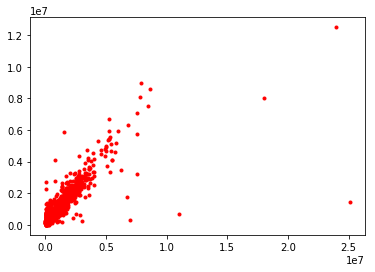

In [297]:
plt.plot(y_test_fe, y_gbr_test, 'r.')

In [299]:
cross_val_score(clf, X_fe, y_fe, cv=5)

array([ 0.68892249,  0.64399859,  0.70699381,  0.38808196, -2.14687559])

In [ ]:
Gradien